# Phase 2 : Feature Engineering (code de Valentine pour l'instant)

In [1]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


In [3]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
print("Chargement du dataset...")
df = pd.read_csv("../data/processed/NIGERIA_WFP_ADMIN1.csv")

# Conversion Unités (Flux -> mm/mois)
if 'Rainf_f_tavg' in df.columns:
    if df['Rainf_f_tavg'].mean() < 1: 
        df['Rainfall_mm'] = df['Rainf_f_tavg'] * 86400 * 30.4
    else:
        df['Rainfall_mm'] = df['Rainf_f_tavg']




Chargement du dataset...


1. Donnees brutes chargees : 973 lignes
2. Apres Feature Engineering : 887 lignes
   -> Lignes perdues : 86 (Correspond aux 3 derniers mois uniquement)

--- DEMARRAGE DU CHECK-UP ---
[SUCCES] Aucun NaN dans les colonnes critiques.
[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).


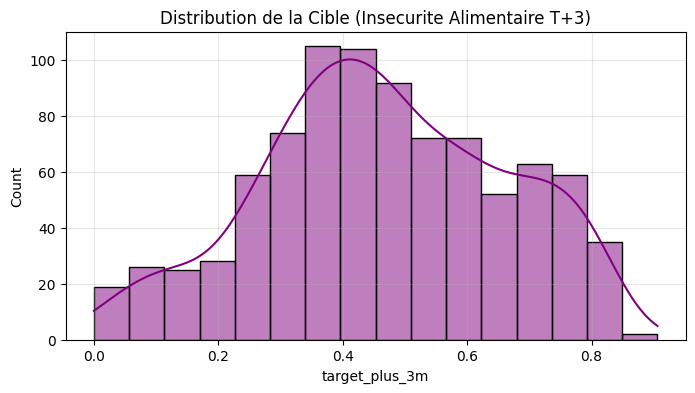


Fichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
try:
    df = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
    df['time'] = pd.to_datetime(df['time'])
    print(f"1. Donnees brutes chargees : {df.shape[0]} lignes")

    # ==============================================================================
    # 2. FEATURE ENGINEERING (Lags et Rolling windows)
    # ==============================================================================
    def create_features_optimized(df):
        # Tri indispensable par Etat et Date
        df = df.sort_values(by=['NAME_1', 'time']).reset_index(drop=True)
        
        # A. Saisonnalite
        df['month'] = df['time'].dt.month
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        
        # B. Lags & Rolling (Decalages et Moyennes)
        cols_meteo = ['Rainf_f_tavg', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 
                      'Tair_f_tavg', 'Evap_tavg', 'Wind_f_tavg', 'SoilTemp00_10cm_tavg']
        cols_ndvi = ['vim', 'viq']
        
        cols_to_process = cols_meteo + cols_ndvi
        cols_existantes = [c for c in cols_to_process if c in df.columns]

        for col in cols_existantes:
            # Rolling (Moyennes Glissantes)
            for window in [3, 6]:
                col_name = f'{col}_roll{window}m_mean'
                # Calcul de la moyenne sur les mois precedents
                df[col_name] = df.groupby('NAME_1')[col].shift(1).rolling(window=window).mean()
                
                # REMPLISSAGE (Backfill) : On remplit les valeurs manquantes du debut 
                # avec la premiere valeur valide disponible pour ne pas perdre de lignes.
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

            # Lags (Decalages simples)
            for lag in [1, 3, 6]:
                col_name = f'{col}_lag{lag}'
                df[col_name] = df.groupby('NAME_1')[col].shift(lag)
                
                # REMPLISSAGE (Backfill)
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

        # C. Targets (Cibles Futures)
        # On ne remplit pas ici car on ne peut pas inventer le futur.
        for horizon in [1, 3]:
            df[f'target_plus_{horizon}m'] = df.groupby('NAME_1')['inadequate'].shift(-horizon)

        # D. Nettoyage Final
        # On ne supprime que les lignes ou la CIBLE manque (les 3 derniers mois)
        df_final = df.dropna(subset=['target_plus_3m'])
        
        return df_final

    # Execution
    df_engineered = create_features_optimized(df)
    print(f"2. Apres Feature Engineering : {df_engineered.shape[0]} lignes")
    perte = df.shape[0] - df_engineered.shape[0]
    print(f"   -> Lignes perdues : {perte} (Correspond aux 3 derniers mois uniquement)")


    # ==============================================================================
    # 3. QUALITY CHECK (VERIFICATION)
    # ==============================================================================
    print("\n--- DEMARRAGE DU CHECK-UP ---")
    
    # Check 1: Valeurs Manquantes (NaNs)
    cols_check = ['target_plus_3m', 'Rainf_f_tavg_lag6', 'vim_roll3m_mean']
    cols_exist = [c for c in cols_check if c in df_engineered.columns]
    nans = df_engineered[cols_exist].isna().sum().sum()
    
    if nans == 0:
        print("[SUCCES] Aucun NaN dans les colonnes critiques.")
    else:
        print(f"[ATTENTION] Il reste {nans} valeurs manquantes.")
        print(df_engineered[cols_exist].isna().sum())

    # Check 2: Coherence Temporelle (Target Shift)
    etat = df_engineered['NAME_1'].unique()[0]
    df_zone = df_engineered[df_engineered['NAME_1'] == etat].sort_values('time')
    
    if len(df_zone) > 10:
        idx = 10
        row = df_zone.iloc[idx]
        date_t = row['time']
        target_stored = row['target_plus_3m']
        
        date_target = date_t + pd.DateOffset(months=3)
        row_target = df_zone[df_zone['time'] == date_target]
        
        if not row_target.empty:
            actual_val = row_target['inadequate'].values[0]
            diff = abs(target_stored - actual_val)
            
            if diff < 1e-4:
                print(f"[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).")
            else:
                print(f"[ECHEC] Incoherence temporelle (Diff: {diff})")
        else:
            print("Info : Impossible de verifier le futur pour cette date (hors limites)")

    # Check 3: Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_engineered['target_plus_3m'], kde=True, color='purple')
    plt.title('Distribution de la Cible (Insecurite Alimentaire T+3)')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Sauvegarde
    df_engineered.to_csv('NIGERIA_WFP_ENGINEERED.csv', index=False)
    print("\nFichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv")

except Exception as e:
    print(f"Erreur : {e}")